## Recall dynamics for simulator comparison

### Imports and definitions

In [1]:
import sys
import os
from subprocess import run, PIPE
import shutil
import re
from pathlib import Path

current_folder = globals()['_dh'][0]
sys.path.append(os.path.join(current_folder, "../../analysis"))
from extractAverageQMI import *
import plotSimResultsComparisonMeanSEM as plotc
from plotQMICoreSize import plotQMIGraphs, plotQMIBarGroups

src_dir = os.path.abspath(os.path.join(current_folder, "../../simulation-code/build_scripts_misc")) # directory where the simulation code is located
bin_dir = os.path.abspath(os.path.join(current_folder, "../../simulation-bin/run_binary_misc")) # directory where the simulation binaries are located
data_root_dir = os.path.join(bin_dir, "recall_varied_pattern_size") # data root directory for the simulations
config = {"synapses" : {"h_0" : 4.20075,
                        "early_phase" : {
                            "theta_p" : 3.0, 
                            "theta_d" : 1.2,
                            "Ca_pre" : 0.6,
                            "Ca_post" : 0.16548}
                       }
         } # model configuration, required for simulation call

### Function to call compilation

In [2]:
#########################################################
# compileSimulationCode
# Compiles the simulation code for a given case
# - case: name of the special case to be used (as defined in 'simulation-code/SpecialCases.hpp')
def compileSimulationCode(case):
    
    os.chdir(src_dir)
    cmnd = "/bin/sh"
    args = f"compile_{case}"
    result = run([cmnd, args], stdout=PIPE, stderr=PIPE, universal_newlines=True)
    print(result.stdout, result.stderr)

### Function to run simulation batches

In [3]:
#########################################################
# runSimulations
# Runs a certain number of simulation trials for the given protocol;
# subsequently calculates recall performance measures Q and MI averaged over trials
# - protocol: name of the protocol to be used ("10s-recall" or "8h-recall")
# - num_trials [optional]: number of trials (not needed if `only_analyze` is set)
# - remove_existing [optional]: if True, remove existent data root directory
# - only_analyze [optional]: if True, only do analysis of existent data
def runSimulations(protocol, num_trials = 50, remove_existing = True, only_analyze = False):
    
    #pattern_sizes = [50, 100, 150, 200, 250, 300] # pattern sizes to be considered
    pattern_sizes = [100, 150, 200, 250] # pattern sizes to be considered
    
    orig_working_dir = os.getcwd() # save the working directory
    data_path_protocol = os.path.join(data_root_dir, protocol) # data directory for the specific protocol

    if not only_analyze:
        compileSimulationCode("recall_varied_size")
    
        if not os.path.isdir(data_root_dir):
            os.mkdir(data_root_dir)
        elif remove_existing:
            shutil.rmtree(data_root_dir)
            os.mkdir(data_root_dir)

        # simulate trials
        for trial in range(num_trials):
            print("--------------------------------------------")
            print(f"Trial {trial + 1}:")

            # create the directory for this protocol
            if not os.path.isdir(data_path_protocol):
                os.mkdir(data_path_protocol)

            for pattern_size in pattern_sizes:
                print("--------------------------------------------")
                print(f"Pattern size {pattern_size}:")

                # prepare the commandline call
                cmnd = f"../../net{pattern_size}.out"
                args = ["-Nl_exc=40", "-Nl_inh=20", "-pc=0.1",
                        "-learn=TRIPLETf100",
                        "-w_ei=2", "-w_ie=4.0", "-w_ii=4.0",
                        "-I_0=0.15", "-sigma_WN=0.05",
                        f"-theta_p={config['synapses']['early_phase']['theta_p']}",
                        f"-theta_d={config['synapses']['early_phase']['theta_d']}",
                        f"-Ca_pre={config['synapses']['early_phase']['Ca_pre']}",
                        f"-Ca_post={config['synapses']['early_phase']['Ca_post']}",
                        f"-purpose=Learn., {protocol} {trial}"]
                if protocol == "10s-recall":
                    args.extend(["-recall=F100D1at20.0", "-t_max=30.0"])
                elif protocol == "8h-recall":
                    args.extend(["-recall=F100D1at28810.0", "-t_max=28820.0"])
                else:
                    raise ValueError(f"Protocol not supported: '{protocol}'.")

                # run the simulation
                os.chdir(data_path_protocol)
                result = run([cmnd, *args], stdout=PIPE, stderr=PIPE, universal_newlines=True)

                # print cleared output
                if trial == 0:
                    result_stdout_cleaned = re.sub(".*Progress: .*\n?", "", result.stdout)
                    print(result_stdout_cleaned, result.stderr)
                else:
                    print("<output suppressed>")
    
    # extract recall performance measures Q and MI and average over trials
    extractAverageQMI(data_path_protocol,
                      N_exc = 1600,
                      N_inh = 400,
                      pattern_sizes = pattern_sizes,
                      output = "final")

### Recall after 10 seconds

In [4]:
runSimulations("10s-recall", 50, remove_existing = False)
#runSimulations("10s-recall", only_analyze = True)

Pattern size 100 (50 trials):
  nu_exc = 7.001849999999999 +- 0.39381549018051903
  nu_as = 92.43119999999999 +- 0.16005917273155718
  nu_ans = 5.800800000000001 +- 1.451642054041293
  nu_ctrl = 4.19424 +- 0.3986829510017969
  nu_inh = 16.0588 +- 0.581843095477726
  Q = 0.01737928254841486 +- 0.014595950453974355
  MI = 0.661181740485683 +- 0.047830081507200244
  selfMIL = 2.6470704927904247 +- 0.0830572811891912
Pattern size 150 (50 trials):
  nu_exc = 10.07715 +- 0.5451009221292168
  nu_as = 92.57866666666665 +- 0.1615570495896422
  nu_ans = 8.724799999999998 +- 1.57567624470191
  nu_ctrl = 5.879779310344828 +- 0.5459426396776007
  nu_inh = 21.463199999999997 +- 0.777424292527732
  Q = 0.03073342868891417 +- 0.014030054731789905
  MI = 0.860468900979187 +- 0.06557148386673695
  selfMIL = 2.8462859015566484 +- 0.08509236369204119
Pattern size 200 (50 trials):
  nu_exc = 13.007475 +- 0.5667230639827534
  nu_as = 92.79079999999998 +- 0.2087165835406894
  nu_ans = 11.070000000000002 +- 1

### Recall after 8 hours

In [5]:
runSimulations("8h-recall", 50, remove_existing = False)
#runSimulations("8h-recall", only_analyze = True)

Pattern size 100 (50 trials):
  nu_exc = 7.715324999999999 +- 0.4003603136423438
  nu_as = 92.4776 +- 0.19164763584905173
  nu_ans = 7.105599999999999 +- 1.8247774927259441
  nu_ctrl = 4.910240000000001 +- 0.39559162066471537
  nu_inh = 17.1367 +- 0.6253322463837503
  Q = 0.023738174096152295 +- 0.018299239441945427
  MI = 0.709421685705935 +- 0.05121189707325539
  selfMIL = 2.6490723129309335 +- 0.0845583314057885
Pattern size 150 (50 trials):
  nu_exc = 11.203875 +- 0.4794743780528671
  nu_as = 92.81013333333334 +- 0.2451090367760775
  nu_ans = 10.191466666666667 +- 1.691880591681321
  nu_ctrl = 7.035227586206896 +- 0.4611656876365839
  nu_inh = 23.229900000000008 +- 0.7209160060333671
  Q = 0.03398421767468382 +- 0.015526918847432096
  MI = 0.9408431378223954 +- 0.06161127640154372
  selfMIL = 2.860986824127313 +- 0.08690033959887156
Pattern size 200 (50 trials):
  nu_exc = 14.709475 +- 0.8670880664174021
  nu_as = 93.3848 +- 0.8033761413496133
  nu_ans = 13.951600000000001 +- 2.584

### Plots

Creating graph plot of 10s-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.
Creating graph plot of 8h-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.


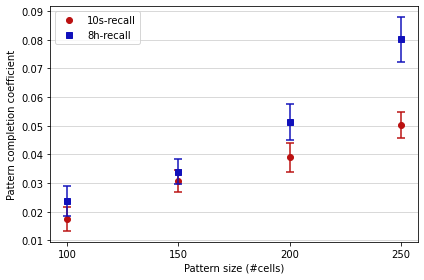

Creating graph plot of 10s-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.
Creating graph plot of 8h-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.


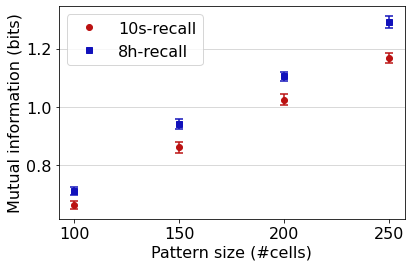

Creating bar group plot of 10s- and 8h-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.


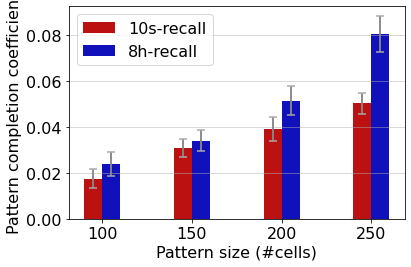

Creating bar group plot of 10s- and 8h-recall over the following core sizes: [100 150 200 250].
Assumed (read out) number of trials: 50.


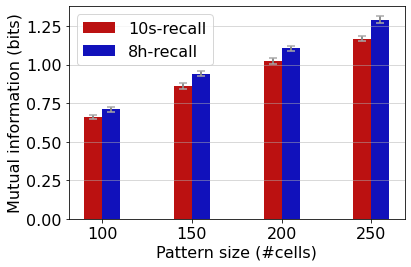

In [6]:
data_file_10s = os.path.join(data_root_dir, "10s-recall", "data_Q_MI.txt")
data_file_8h = os.path.join(data_root_dir, "8h-recall", "data_Q_MI.txt")
plotQMIGraphs(data_file_10s, data_file_8h, show=True, store=False)
plotQMIBarGroups(data_file_10s, data_file_8h, show=True, store=False)